In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sparse
from scipy.sparse.linalg import eigsh, expm_multiply, expm

### Correlator generalized for L sites

In [2]:
def gen_spin_operators(L):
    """Returns the spin-1/2 operators sigma_x and sigma_z for L sites."""
    X = sparse.csr_array(np.array([[0.,1.],[1.,0.]]))
    Z = sparse.csr_array(np.diag([1.,-1.]))
    
    d = 2
    Sx_list = []
    Sz_list = []
    
    for i_site in range(L):
        # ops on first site
        if i_site == 0: 
            Sx = X
            Sz = Z 
        else: 
            Sx = sparse.csr_array(np.eye(d))
            Sz = sparse.csr_array(np.eye(d))
        # ops on remaining sites
        for j_site in range(1, L):
            if j_site == i_site: 
                Sx = sparse.kron(Sx, X, 'csr')
                Sz = sparse.kron(Sz, Z, 'csr')
            else:
                Sx = sparse.kron(Sx, np.eye(d), 'csr')
                Sz = sparse.kron(Sz, np.eye(d), 'csr')
        Sx_list.append(Sx)
        Sz_list.append(Sz)
    
    return Sx_list, Sz_list

def gen_hamiltonian_terms(L, Sx_list, Sz_list):
    """Generates the XX and Z terms of the Hamiltonian."""
    D = Sx_list[0].shape[0]
    print(f'System with {L:d} sites, Hilbert space dimension is {D:d}.')

    # Ising interaction
    Hxx = Sx_list[0] @ Sx_list[1]
    for i in range(1, L-1):
        Hxx += Sx_list[i] @ Sx_list[i+1]
    Hxx += Sx_list[L-1] @ Sx_list[0] #PBC
    
    # onsite field terms
    Hz = Sz_list[0]
    for Sz in Sz_list[1:L]:
        Hz += Sz

    
    return Hxx, Hz

In [3]:
# define Hamiltonian terms
L = 11
J = 1.
g = 2.    


Sx_list, Sz_list = gen_spin_operators(L)
Hxx, Hz = gen_hamiltonian_terms(L, Sx_list, Sz_list)

H = -J * Hxx -g * Hz

System with 11 sites, Hilbert space dimension is 2048.


In [4]:
# compute correlator
dt = 1e-2
n = 11
N = 2**n

# get ground state
E, psi = eigsh(H, k=1, which='SA')
E0, psi = np.squeeze(E), np.squeeze(psi)
print('Ground state energy:', E0)
psi_0 = psi.copy()

# put in excitation
psi = Sx_list[L//2] @ psi
E1 = np.dot(psi.conj(), H @ psi).real
print('Excited state energy:', E1)

psil = np.array([Sx_list[l] @ psi_0 for l in range(L)])


# evolve states in time
psis = expm_multiply(-1j * H,
                     psi,
                     start=0,
                     stop=N*dt,
                     num=N,
                     endpoint=False)

# calculate correlators C = <psi| e^iHt X_ell e^-iHt X_L/2 |psi>
Cs = np.einsum('lj, ij -> li', psil.conj(), psis) * np.exp(1j * E0 * np.arange(N) * dt)

Ground state energy: -23.39812906532336
Excited state energy: -19.66153587541126


In [5]:
print(Cs.shape) 
#form is (L,2**n) <-> (X,T)
print("total number of points of Corr func: ", Cs.shape[0]* Cs.shape[1])

(11, 2048)
total number of points of Corr func:  22528


Text(0.5, 1.0, 'correlation function evaluated on 11 sites')

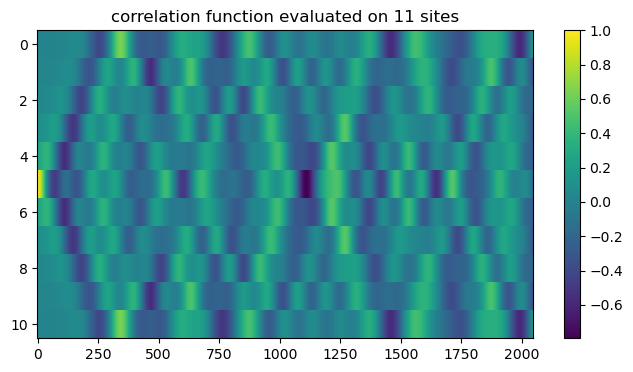

In [6]:
plt.figure(figsize=(8, 4))
plt.imshow(Cs.real, aspect = 'auto', 
           interpolation = 'none'
           )

plt.colorbar()
plt.title("correlation function evaluated on " + f"{L}" + " sites")

In [7]:
import importlib

import sys
sys.path.append('/Users/giovanniconcheri/Desktop/ResearchJob/Student-Research-Job/Chebyshev')
sys.path.append('/Users/giovanniconcheri/Desktop/ResearchJob/Student-Research-Job/TCI')
sys.path.append("/home/t30/all/go56vod/Desktop/Student-Research-Job/Chebyshev")
sys.path.append("/home/t30/all/go56vod/Desktop/Student-Research-Job/TCI")

import Chebyshev as Cbs
import TCI_Lsite as TCI
import FourierTransform as FT
import TCI_Lsite_accumulative_v2 as TCI_a
import TCI_Lsite_accumulative_v1 as TCI_b
import TCI_Lsite_final as TCI_final

importlib.reload(Cbs)
importlib.reload(TCI)
importlib.reload(FT)
importlib.reload(TCI_a)
importlib.reload(TCI_b)
importlib.reload(TCI_final)

<module 'TCI_Lsite_final' from '/Users/giovanniconcheri/Desktop/ResearchJob/Student-Research-Job/TCI/TCI_Lsite_final.py'>

Compute Fourier transform
finished
1024
(11,)
11


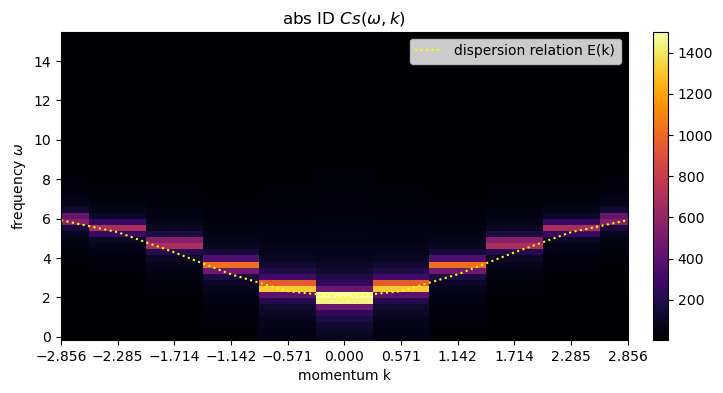

In [8]:
Swk, momenta, freqs = FT.get_Swk(Cs.T, L, dt = dt)
FT.plot_Swk(Swk, momenta, freqs, g, J, interval = 50)


# Interpolation with TCI

In [10]:
D = L

func_vals = Cs.T #Cs is in the form (X,T)

#first we define the function f(t)
# which returns the slice of func_vals along x for a specific time 
f_t = lambda *t: Cs.reshape((D,) + (2,) * n)[:,*t]

### NON accumulative TCI

In [12]:
# #here we have to define func as the initialization of the class
# func = TCI.function(f_t)

# print("total number of points of Corr func: ", Cs.shape[0]* Cs.shape[1])
# print()

# As, _, eval, err_2, err_max, func_interp = TCI.tensor_cross_interpolation(func,         # function to be interpolated
#                                    func_vals,    
#                                    D,
#                                    L=n,          # number of MPS tensors
#                                    eps_or_chi=40, # bond dimension
#                                    iters=1)       # number of back-and-forth sweeps

# print(np.linalg.norm(func_vals), np.max(np.abs(func_vals)))


func_1 = TCI_final.function(f_t)

print("total number of points of Corr func: ", Cs.shape[0]* Cs.shape[1])
print()

As, _, eval, err_2, err_max, func_interp = TCI_final.tensor_cross_interpolation(func_1,         # function to be interpolated
                                   func_vals,    
                                   D,
                                   L=n,          # number of MPS tensors
                                   mode='reset',
                                   eps_or_chi=40, # bond dimension
                                   iters=1)       # number of back-and-forth sweeps

print(np.linalg.norm(func_vals), np.max(np.abs(func_vals)))

total number of points of Corr func:  22528

Using reset TCI
err_max:  1.8278600746894826e-14
err_2:  9.300123113949444e-15

repeated evaluations:  5692
unique evaluations 2048
unique + repeated:  7740
total evaluations:  7740

48.643524004831114 1.0000000000000038


In [185]:
importlib.reload(TCI_a)
importlib.reload(TCI_b)

<module 'TCI_Lsite_accumulative_v1' from '/Users/giovanniconcheri/Desktop/ResearchJob/Student-Research-Job/TCI/TCI_Lsite_accumulative_v1.py'>

### Accumulative TCI version 2!

This version is not stable! Version 1 is the stable one!

In [186]:
#here we have to define func as the initialization of the class
func_acc_v2 = TCI_a.function(f_t)

print("total number of points of Corr func: ", Cs.shape[0]* Cs.shape[1])
print()

As, _, eval, err_2, err_max, func_interp = TCI_a.accumulative_tensor_cross_interpolation(func_acc_v2,         # function to be interpolated
                                   func_vals,    
                                   D,
                                   L=n,          # number of MPS tensors
                                   iters=15)       # number of back-and-forth sweeps

print(np.linalg.norm(func_vals), np.max(np.abs(func_vals)))

total number of points of Corr func:  22528

(1, 2, 1, 11)
(1, 2, 1)
(1, 2, 1)
err_max:  0.017223829780611762
err_2:  0.0019124081056655319
evals:  1536

repeated evaluations:  51372
unique evaluations 1536
unique + repeated:  52908
total evaluations:  52908

48.64352400483691 1.0000000000000036


### Accumulative TCI version 1!

In [13]:
#here we have to define func as the initialization of the class
func_acc = TCI_b.function(f_t)

print("total number of points of Corr func: ", Cs.shape[0]* Cs.shape[1])
print()

As, _, eval, err_2, err_max, func_interp = TCI_b.accumulative_tensor_cross_interpolation(func_acc,         # function to be interpolated
                                   func_vals,    
                                   D,
                                   L=n,          # number of MPS tensors
                                   iters=10)       # number of back-and-forth sweeps

print(np.linalg.norm(func_vals), np.max(np.abs(func_vals)))

print()

func_acc1 = TCI_b.function(f_t)

As, _, eval, err_2, err_max, func_interp = TCI_b.accumulative_tensor_cross_interpolation(func_acc1,         # function to be interpolated
                                   func_vals,    
                                   D,
                                   L=n,          # number of MPS tensors
                                   iters=5,      # number of back-and-forth sweeps
                                   euclidean = False)   
  

total number of points of Corr func:  22528

err_max:  0.00018734069366129722
err_2:  0.00010133212782615671

repeated evaluations:  20182
unique evaluations 946
unique + repeated:  21128
total evaluations:  21128

48.643524004831114 1.0000000000000038

err_max:  0.0015553481629731808
err_2:  0.0007136892159976497

repeated evaluations:  4108
unique evaluations 408
unique + repeated:  4516
total evaluations:  4516



In [15]:
#here we have to define func as the initialization of the class
func_acc_final = TCI_final.function(f_t)

print("total number of points of Corr func: ", Cs.shape[0]* Cs.shape[1])
print()

As, _, eval, err_2, err_max, func_interp = TCI_final.tensor_cross_interpolation(func_acc_final,         # function to be interpolated
                                   func_vals,    
                                   D,
                                   L=n,          # number of MPS tensors
                                   mode='accumulative',
                                   iters=10)       # number of back-and-forth sweeps

print(np.linalg.norm(func_vals), np.max(np.abs(func_vals)))

total number of points of Corr func:  22528

Using accumulative TCI
err_max:  0.00018734069366129722
err_2:  0.00010133212782615671

repeated evaluations:  20182
unique evaluations 946
unique + repeated:  21128
total evaluations:  21128

48.643524004831114 1.0000000000000038


### Check which error, used in the accumulative procedure (Pi-Pi_tilde) works better for convergence of algorithm. Either the 2-norm error (euc) or the absolute value (abs)

err_max:  0.6669321016600888
err_2:  0.8136799705211734

repeated evaluations:  20402
unique evaluations 946
unique + repeated:  21348
total evaluations:  21348

err_max:  0.6482955460344416
err_2:  0.8189108460061529

repeated evaluations:  20622
unique evaluations 946
unique + repeated:  21568
total evaluations:  21568

err_max:  0.7076567396762441
err_2:  0.6970085043228296

repeated evaluations:  21334
unique evaluations 946
unique + repeated:  22280
total evaluations:  22280

err_max:  0.5896146707451064
err_2:  0.6665314297153524

repeated evaluations:  22042
unique evaluations 950
unique + repeated:  22992
total evaluations:  22992

err_max:  0.44787491269334406
err_2:  0.5150234323683037

repeated evaluations:  23606
unique evaluations 950
unique + repeated:  24556
total evaluations:  24556

err_max:  0.5803357982764462
err_2:  0.5076867919218201

repeated evaluations:  25162
unique evaluations 958
unique + repeated:  26120
total evaluations:  26120

err_max:  0.272998736730364

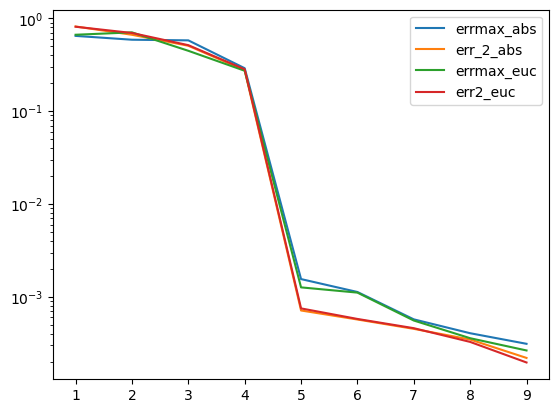

In [188]:
errmax_euc = []
err_2_euc = []
errmax_abs = []
err_2_abs = []
iterlist = [i for i in range(1,10)]

for i in iterlist:
    _, _, _, err_2, err_max, func_interp = TCI_b.accumulative_tensor_cross_interpolation(func_acc,         # function to be interpolated
                                   func_vals,    
                                   D,
                                   L=n,          # number of MPS tensors
                                   iters=i)       # number of back-and-forth sweeps
    errmax_euc.append(err_max)
    err_2_euc.append(err_2)

    _, _, _, err_2, err_max, func_interp = TCI_b.accumulative_tensor_cross_interpolation(func_acc,         # function to be interpolated
                                   func_vals,    
                                   D,
                                   L=n,          # number of MPS tensors
                                   iters=i,
                                   euclidean = False)

    errmax_abs.append(err_max)
    err_2_abs.append(err_2)

plt.plot(iterlist, errmax_abs, label = 'errmax_abs')
plt.plot(iterlist, err_2_abs, label = 'err_2_abs')
plt.plot(iterlist, errmax_euc, label = 'errmax_euc')
plt.plot(iterlist, err_2_euc, label = 'err2_euc')
plt.yscale("log")
plt.legend()
plt.show()

/Users/giovanniconcheri/miniconda3/envs/Computational/lib/python3.13/site-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/giovanniconcheri/miniconda3/envs/Computational/lib/python3.13/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


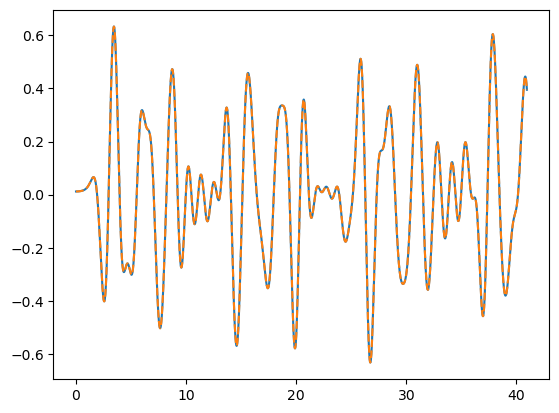

In [106]:
ts = np.arange(N)*dt

plt.plot(ts, func_vals[:,0])
plt.plot(ts, func_interp[:,0], '--')

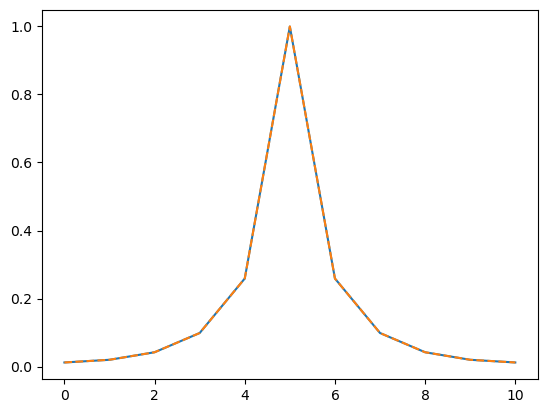

In [107]:
xs = np.arange(L)
plt.plot(xs, func_vals[0,:], "-")
plt.plot(xs, func_interp[0,:], "--")

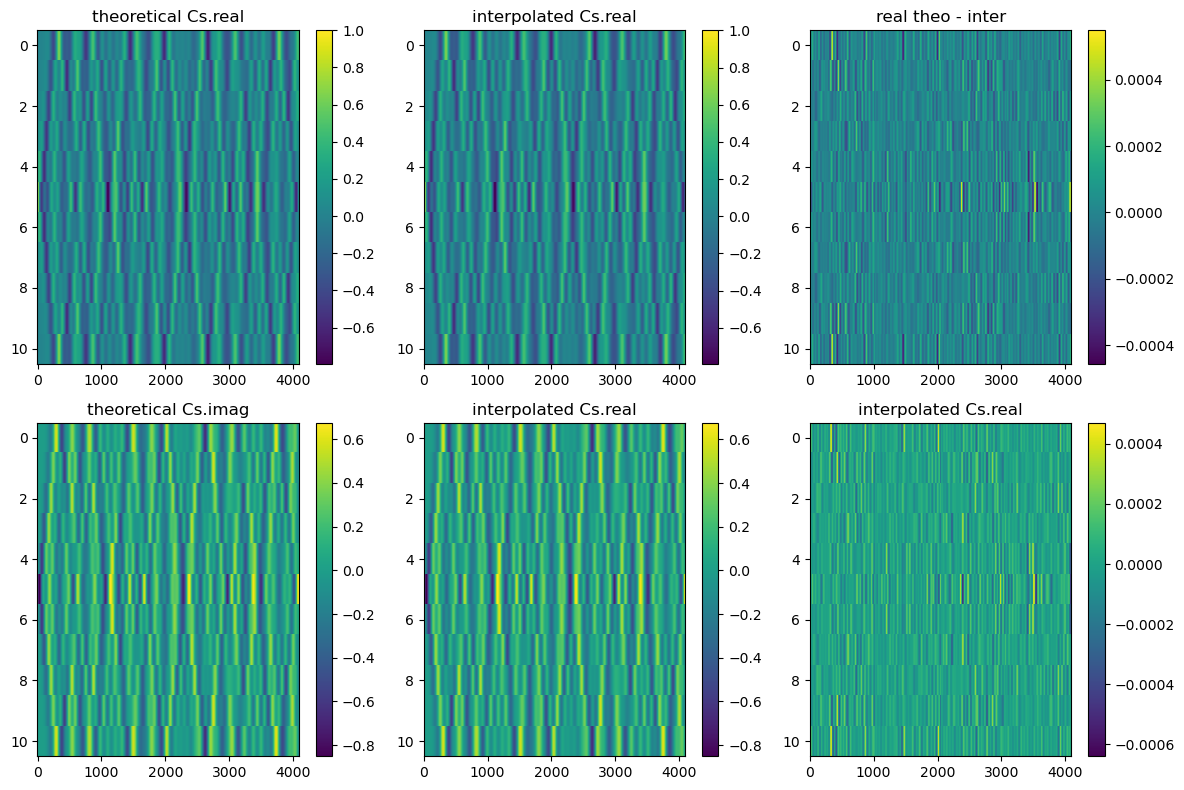

In [108]:
rows, cols = 2, 3  # Define grid dimensions
a, b = Cs.shape
interp_Cs = func_interp.T.reshape(a, b)

fig, axs = plt.subplots(rows, cols, figsize=(12, 8))

im = axs[0,0].imshow(Cs.real, aspect = 'auto', interpolation = 'none')
cbar = fig.colorbar(im, ax = axs[0,0], 
                    #fraction=0.046, pad=0.04
                    )
#cbar.ax.tick_params(labelsize=8)
axs[0,0].set_title('theoretical Cs.real')

im = axs[0,1].imshow(np.real(interp_Cs), aspect = 'auto', interpolation = 'none')
fig.colorbar(im, ax = axs[0,1])
axs[0,1].set_title('interpolated Cs.real')

im =axs[0,2].imshow(Cs.real-np.real(interp_Cs), aspect = 'auto', interpolation = 'none')
fig.colorbar(im, ax = axs[0,2])
axs[0,2].set_title('real theo - inter')

im = axs[1,0].imshow(Cs.imag, aspect = 'auto', interpolation = 'none')
fig.colorbar(im, ax = axs[1,0])
axs[1,0].set_title('theoretical Cs.imag')

im = axs[1,1].imshow(np.imag(interp_Cs), aspect = 'auto', interpolation = 'none')
fig.colorbar(im, ax = axs[1,1])
axs[1,1].set_title('interpolated Cs.real')

im = axs[1,2].imshow(Cs.imag-np.imag(interp_Cs), aspect = 'auto', interpolation = 'none')
fig.colorbar(im, ax = axs[1,2])
axs[1,2].set_title('interpolated Cs.real')

plt.tight_layout()
plt.show()


### Colormap of theoretical Cs vs interpolated Cs

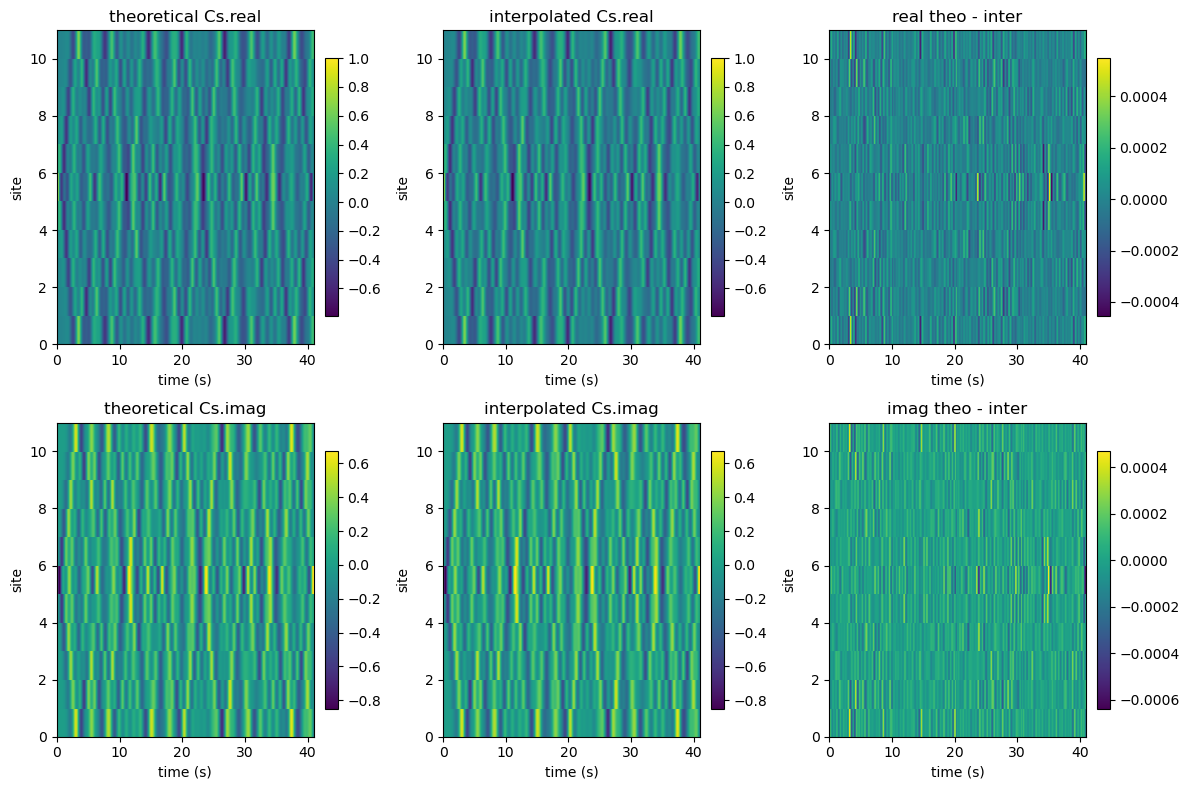

In [109]:
rows, cols = 2, 3  # Define grid dimensions
a, b = Cs.shape #Cs is in the form (X,T)
interp_Cs = func_interp.T.reshape(a, b)



# Data and titles for each subplot
data = [
    (Cs.real, 'theoretical Cs.real'),
    (np.real(interp_Cs), 'interpolated Cs.real'),
    (Cs.real - np.real(interp_Cs), 'real theo - inter'),
    (Cs.imag, 'theoretical Cs.imag'),
    (np.imag(interp_Cs), 'interpolated Cs.imag'),
    (Cs.imag - np.imag(interp_Cs), 'imag theo - inter')
]

# Create subplots
fig, axs = plt.subplots(rows, cols, figsize=(12, 8))

# Loop through data and subplots
for ax, (image, title) in zip(axs.flat, data):
    im = ax.imshow(image, aspect='auto', interpolation='none', origin = 'lower', 
                   extent = [0, N*dt, 0, L])
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)  # Add colorbar
    ax.set_title(title)
    ax.set(xlabel = 'time (s)', ylabel = 'site')

plt.tight_layout()
plt.show()

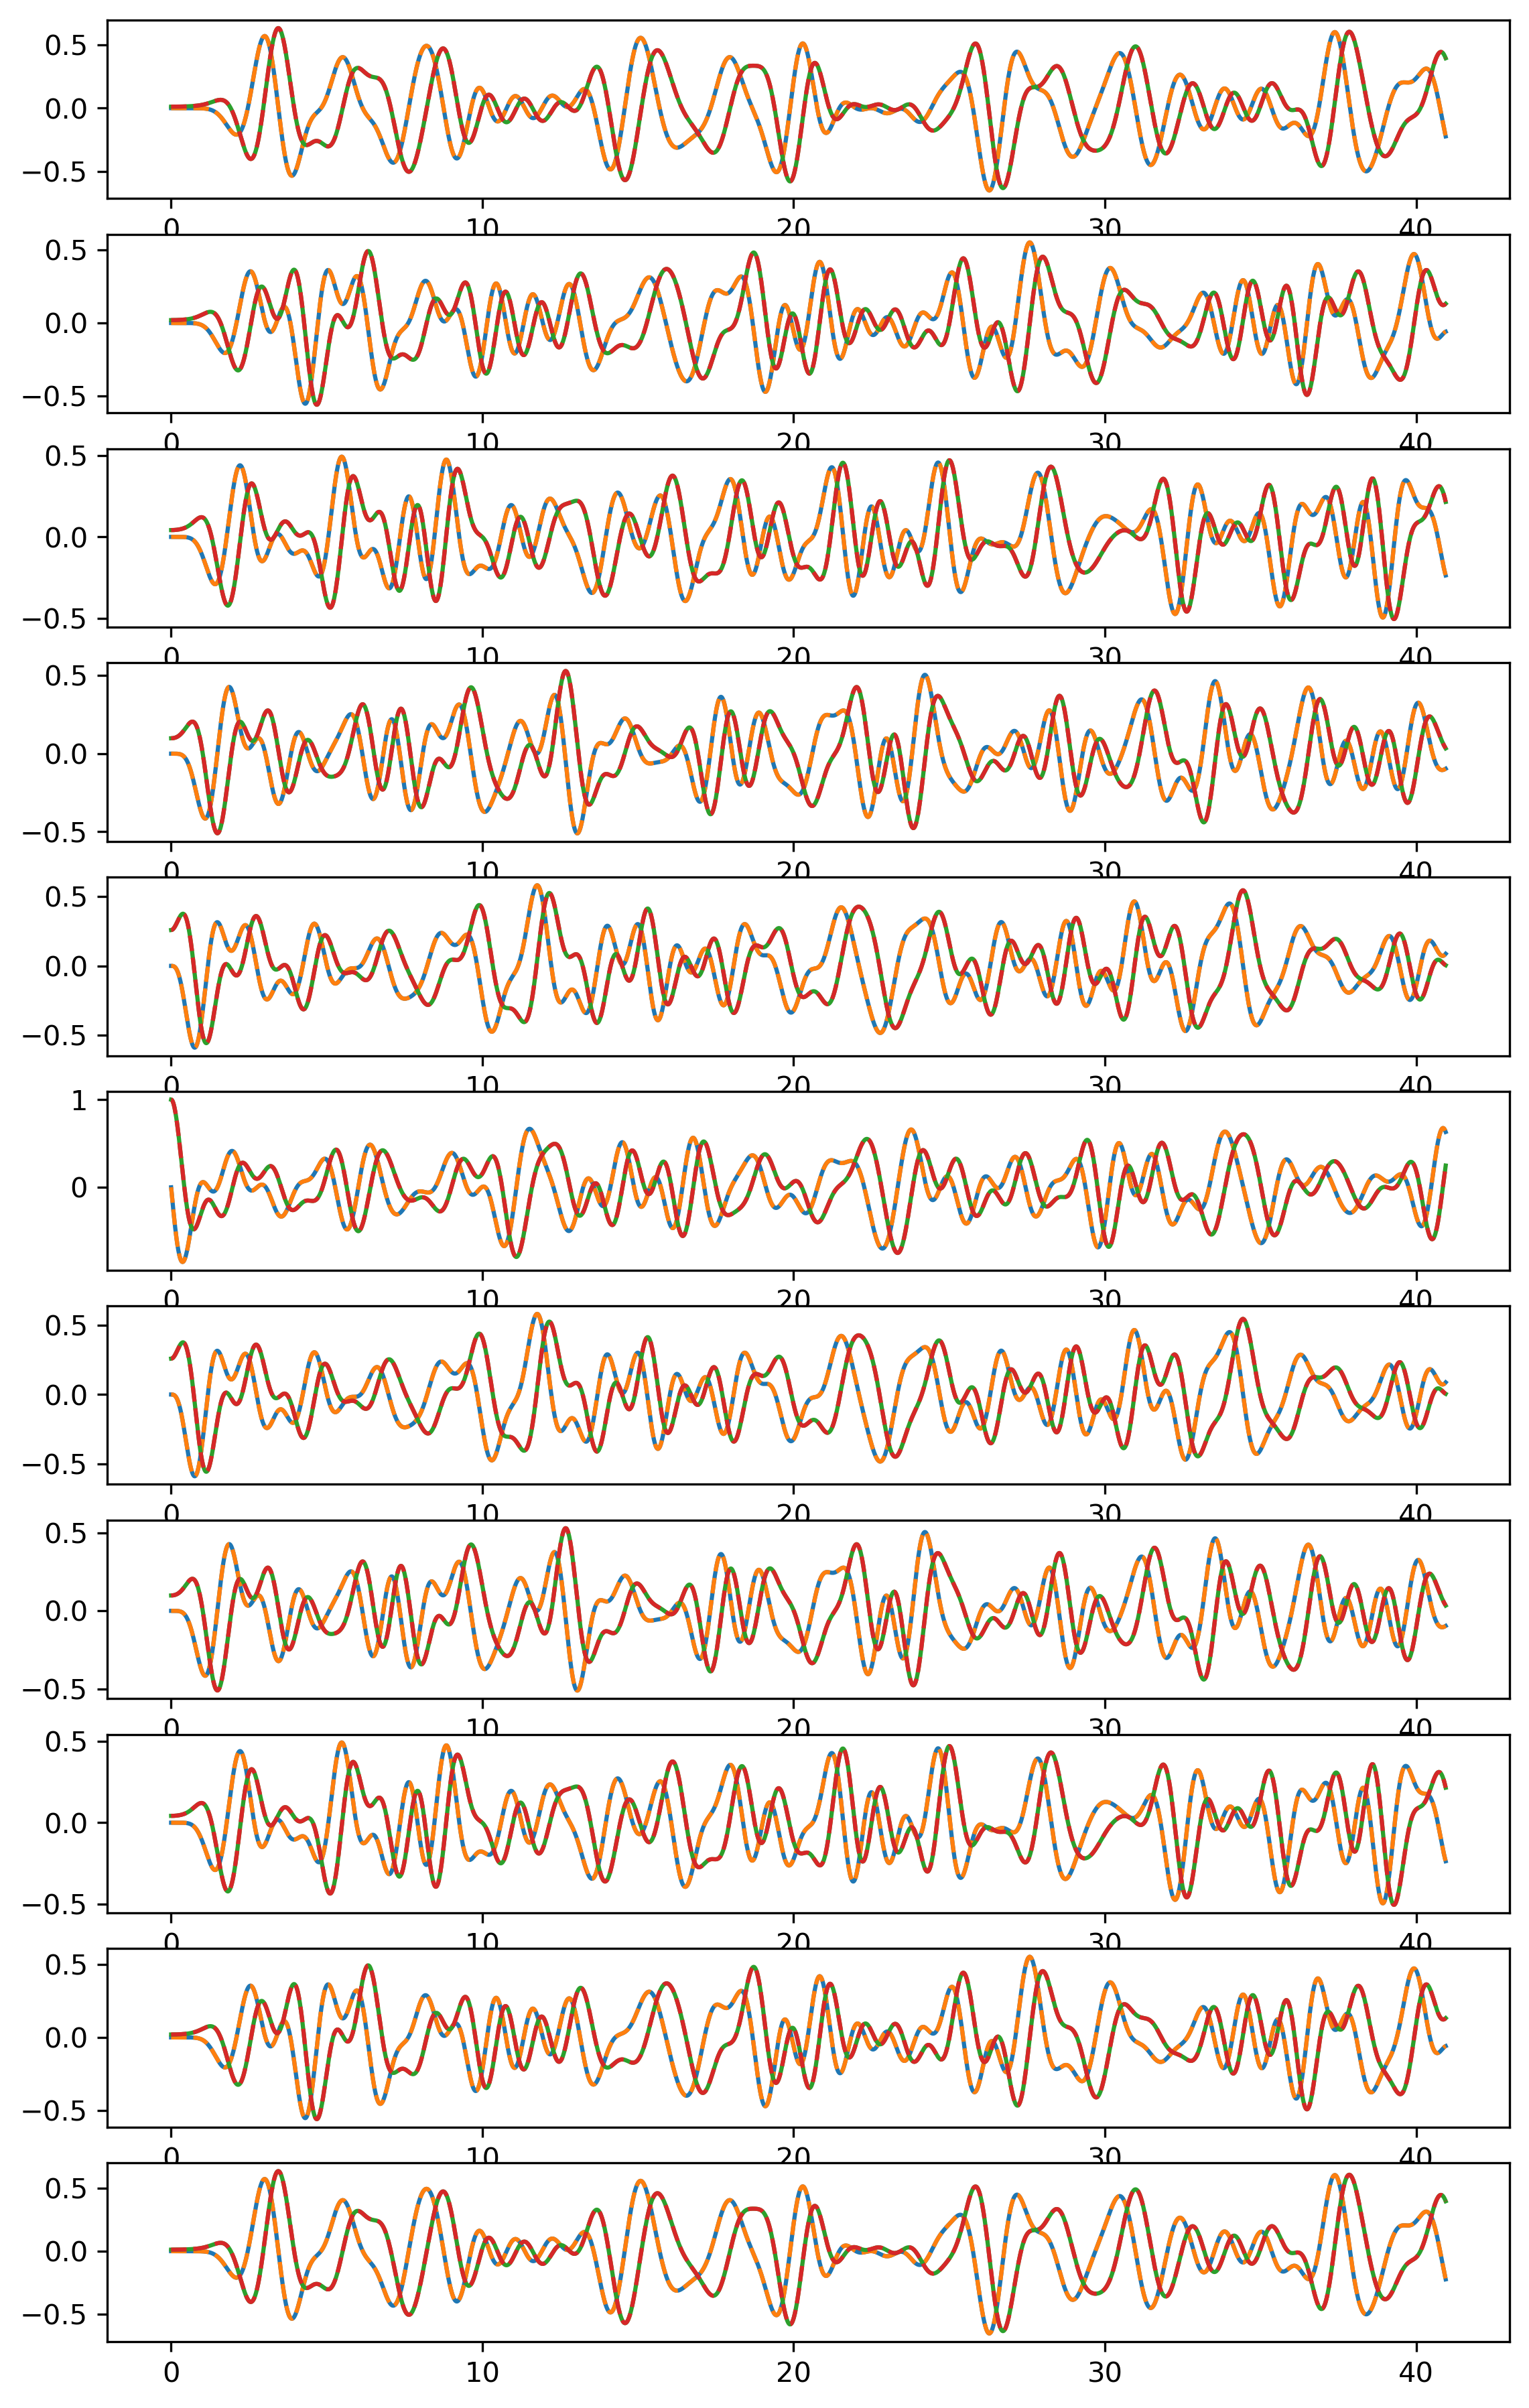

In [110]:
D_list = np.arange(D)

fig, axs = plt.subplots(nrows=D, figsize=(9,15), dpi=300)



for i,item in enumerate(D_list):
    axs[i].plot(ts, np.imag(func_vals[:,item]), '-')
    axs[i].plot(ts, np.imag(func_interp[:,item]), '--')
    axs[i].plot(ts, np.real(func_vals[:,item]), '-')
    axs[i].plot(ts, np.real(func_interp[:,item]), '--')

plt.show()

### Errors vs evaluation for non accumulative TCI 

version 1 (func = TCI.function() inside loop)

<>:41: SyntaxWarning: invalid escape sequence '\c'
<>:41: SyntaxWarning: invalid escape sequence '\c'
/var/folders/6j/zg3nz4053f97fyqx4w2b6pxc0000gn/T/ipykernel_64371/1002591876.py:41: SyntaxWarning: invalid escape sequence '\c'
  plt.plot([], [], ' ', label="Numbers: $\chi$ values")  # Dummy plot for chi explanation


err_max:  0.7044526530056029
err_2:  0.9375695187483201
eval/D:  144

repeated evaluations:  648
unique evaluations 144
unique + repeated:  792
total evaluations:  792

err_max:  0.7124589556840084
err_2:  0.8597234443712028
eval/D:  277

repeated evaluations:  927
unique evaluations 277
unique + repeated:  1204
total evaluations:  1204

err_max:  0.835966047768956
err_2:  0.7753461090062532
eval/D:  304

repeated evaluations:  2084
unique evaluations 304
unique + repeated:  2388
total evaluations:  2388

err_max:  0.4867002064795291
err_2:  0.5857861187378326
eval/D:  540

repeated evaluations:  3424
unique evaluations 540
unique + repeated:  3964
total evaluations:  3964

err_max:  0.379440766824903
err_2:  0.3536293607695155
eval/D:  737

repeated evaluations:  4911
unique evaluations 737
unique + repeated:  5648
total evaluations:  5648

err_max:  0.001850432415252584
err_2:  0.0007837980082996395
eval/D:  1338

repeated evaluations:  6274
unique evaluations 1338
unique + repeated:

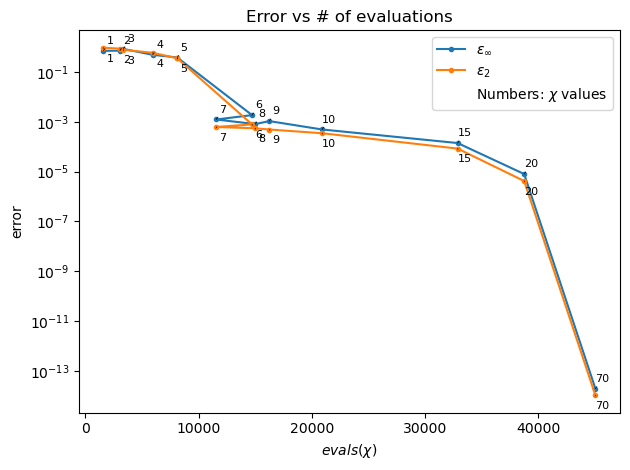

In [172]:
err_max = []
err_2 = []
evals = []
func_interp_list = []

chi_list = [i for i in range(1,10)]
chi_list.extend([i for i in range(10,25,5)])
chi_list.append(70)


for chi in chi_list:
    func = TCI.function(f_t)
    _, _, eval, err2, errmax, func_interp = TCI.tensor_cross_interpolation(func,         # function to be interpolated
                                   func_vals,    
                                   D,
                                   L=n,          # number of MPS tensors
                                   eps_or_chi=chi, # bond dimension
                                   iters=4)       # number of back-and-forth sweeps
    err_max.append(errmax)
    err_2.append(err2)
    evals.append(eval)
    func_interp_list.append(func_interp)

plt.plot(np.array(evals), np.array(err_max), ".-", label = r"$\epsilon_\infty$")
plt.plot(np.array(evals), np.array(err_2), ".-", label = r"$\epsilon_2$")

# Annotate the points with their chi values
for i, chi in enumerate(chi_list):
    # Annotate error_max (first curve)
    plt.annotate(f"{chi}", (evals[i], err_max[i]),
                 textcoords="offset points", xytext=(5, 5), fontsize=8,
                 arrowprops=dict(arrowstyle="-", lw=0.5),
                 ha='center')

    # Annotate error_2 (second curve)
    plt.annotate(f"{chi}", (evals[i], err_2[i]),
                 textcoords="offset points", xytext=(5, -10), fontsize=8,
                 arrowprops=dict(arrowstyle="-", lw=0.5),
                 ha='center')
    
plt.plot([], [], ' ', label="Numbers: $\chi$ values")  # Dummy plot for chi explanation

plt.yscale("log")
plt.xlabel(r"$evals(\chi)$")
plt.ylabel(r"error")
plt.legend()
plt.title("Error vs # of evaluations")
plt.tight_layout()
plt.show()

version 2 (func = TCI.function() outside loop)

<>:42: SyntaxWarning: invalid escape sequence '\c'
<>:42: SyntaxWarning: invalid escape sequence '\c'
/var/folders/6j/zg3nz4053f97fyqx4w2b6pxc0000gn/T/ipykernel_64371/2469465520.py:42: SyntaxWarning: invalid escape sequence '\c'
  plt.plot([], [], ' ', label="Numbers: $\chi$ values")  # Dummy plot for chi explanation


err_max:  0.9734891377797837
err_2:  0.9217900107887141
eval/D:  82

repeated evaluations:  710
unique evaluations 82
unique + repeated:  792
total evaluations:  792

err_max:  0.7124589556840084
err_2:  0.8597234443712028
eval/D:  340

repeated evaluations:  1656
unique evaluations 340
unique + repeated:  1996
total evaluations:  1996

err_max:  0.835966047768956
err_2:  0.7753461090062532
eval/D:  479

repeated evaluations:  3905
unique evaluations 479
unique + repeated:  4384
total evaluations:  4384

err_max:  0.4867002064795291
err_2:  0.5857861187378326
eval/D:  669

repeated evaluations:  7679
unique evaluations 669
unique + repeated:  8348
total evaluations:  8348

err_max:  0.379440766824903
err_2:  0.3536293607695155
eval/D:  1109

repeated evaluations:  12887
unique evaluations 1109
unique + repeated:  13996
total evaluations:  13996

err_max:  0.001850432415252584
err_2:  0.0007837980082996395
eval/D:  1503

repeated evaluations:  20105
unique evaluations 1503
unique + repe

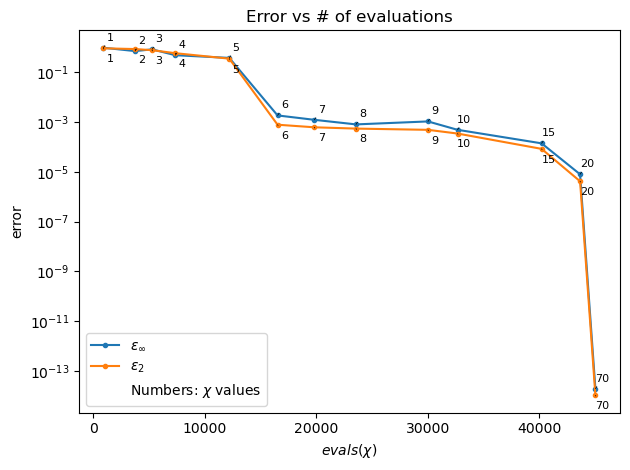

In [175]:

err_max = []
err_2 = []
evals = []
func_interp_list = []

chi_list = [i for i in range(1,10)]
chi_list.extend([i for i in range(10,25,5)])
chi_list.append(70)

func = TCI.function(f_t)


for chi in chi_list:
    _, _, eval, err2, errmax, func_interp = TCI.tensor_cross_interpolation(func,         # function to be interpolated
                                   func_vals,    
                                   D,
                                   L=n,          # number of MPS tensors
                                   eps_or_chi=chi, # bond dimension
                                   iters=4)       # number of back-and-forth sweeps
    err_max.append(errmax)
    err_2.append(err2)
    evals.append(eval)
    func_interp_list.append(func_interp)

plt.plot(np.array(evals), np.array(err_max), ".-", label = r"$\epsilon_\infty$")
plt.plot(np.array(evals), np.array(err_2), ".-", label = r"$\epsilon_2$")

# Annotate the points with their chi values
for i, chi in enumerate(chi_list):
    # Annotate error_max (first curve)
    plt.annotate(f"{chi}", (evals[i], err_max[i]),
                 textcoords="offset points", xytext=(5, 5), fontsize=8,
                 arrowprops=dict(arrowstyle="-", lw=0.5),
                 ha='center')

    # Annotate error_2 (second curve)
    plt.annotate(f"{chi}", (evals[i], err_2[i]),
                 textcoords="offset points", xytext=(5, -10), fontsize=8,
                 arrowprops=dict(arrowstyle="-", lw=0.5),
                 ha='center')
    
plt.plot([], [], ' ', label="Numbers: $\chi$ values")  # Dummy plot for chi explanation

plt.yscale("log")
plt.xlabel(r"$evals(\chi)$")
plt.ylabel(r"error")
plt.legend()
plt.title("Error vs # of evaluations")
plt.tight_layout()
plt.show()

Compute Fourier transform
finished
Compute Fourier transform
finished
2048
(11,)
11
2048
(11,)
11


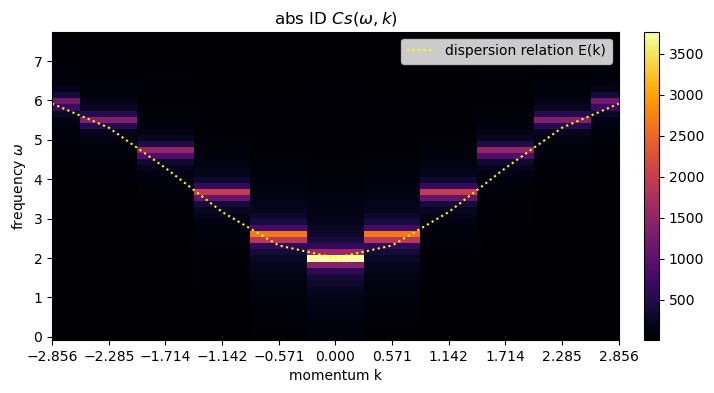

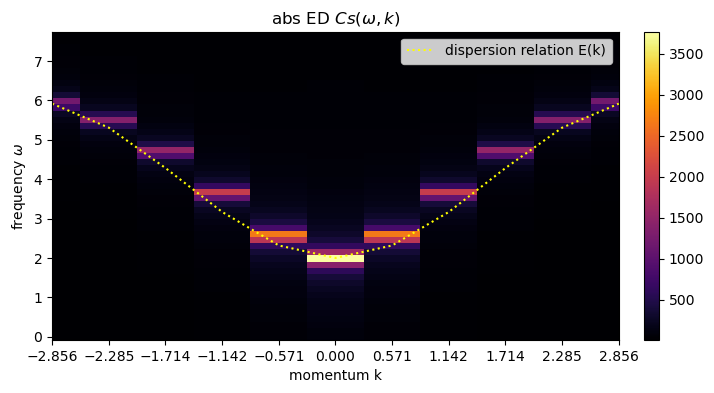

In [112]:
Swk, momenta, freqs = FT.get_Swk(Cs.T, L, dt = dt)
interp_Swk, interp_momenta, interp_freqs = FT.get_Swk(func_interp, L, dt = dt)

FT.plot_Swk(Swk, momenta, freqs, g, J, interval = 50)
FT.plot_Swk(interp_Swk, interp_momenta, interp_freqs, g, J, interval = 50, interp = True)


### Errors vs evaluation for accumulative TCI version 1

<>:37: SyntaxWarning: invalid escape sequence '\c'
<>:37: SyntaxWarning: invalid escape sequence '\c'
/var/folders/6j/zg3nz4053f97fyqx4w2b6pxc0000gn/T/ipykernel_64371/3247362720.py:37: SyntaxWarning: invalid escape sequence '\c'
  plt.plot([], [], ' ', label="Numbers: $\chi$ values")  # Dummy plot for chi explanation


err_max:  0.6669321016600888
err_2:  0.8136799705211734

repeated evaluations:  148
unique evaluations 72
unique + repeated:  220
total evaluations:  220

err_max:  0.7076567396762441
err_2:  0.6970085043228296

repeated evaluations:  574
unique evaluations 138
unique + repeated:  712
total evaluations:  712

err_max:  0.44787491269334406
err_2:  0.5150234323683037

repeated evaluations:  1340
unique evaluations 224
unique + repeated:  1564
total evaluations:  1564

err_max:  0.2729987367303643
err_2:  0.2831533184845511

repeated evaluations:  2506
unique evaluations 310
unique + repeated:  2816
total evaluations:  2816

err_max:  0.0012661466326732082
err_2:  0.0007516265896816379

repeated evaluations:  4108
unique evaluations 408
unique + repeated:  4516
total evaluations:  4516

err_max:  0.0011117950711302953
err_2:  0.0005785479943273669

repeated evaluations:  6210
unique evaluations 518
unique + repeated:  6728
total evaluations:  6728

err_max:  0.0005564095591272572
err_2:  

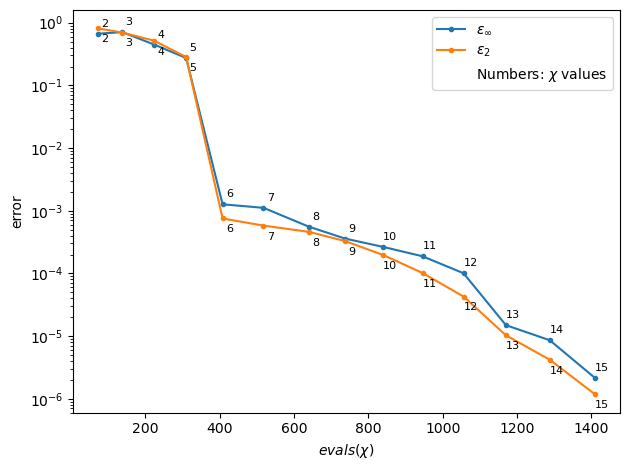

In [198]:
err_max = []
err_2 = []
evals = []
func_interp_list = []
iter_list = [i for i in range(1,15)]


for iter in iter_list:
    func = TCI_b.function(f_t)
    _, _, eval, err2, errmax, func_interp = TCI_b.accumulative_tensor_cross_interpolation(func,         # function to be interpolated
                                   func_vals,    
                                   D,
                                   L=n,          # number of MPS tensors
                                   iters=iter)       # number of back-and-forth sweeps
    err_max.append(errmax)
    err_2.append(err2)
    evals.append(eval)
    func_interp_list.append(func_interp)

plt.plot(np.array(evals), np.array(err_max), ".-", label = r"$\epsilon_\infty$")
plt.plot(np.array(evals), np.array(err_2), ".-", label = r"$\epsilon_2$")

# Annotate the points with their chi values
for i, iter in enumerate(iter_list):
    # Annotate error_max (first curve)
    plt.annotate(f"{iter+1}", (evals[i], err_max[i]),
                 textcoords="offset points", xytext=(5, 5), fontsize=8,
                #  arrowprops=dict(arrowstyle="-", lw=0.5),
                 ha='center')

    # Annotate error_2 (second curve)
    plt.annotate(f"{iter+1}", (evals[i], err_2[i]),
                 textcoords="offset points", xytext=(5, -10), fontsize=8,
                #  arrowprops=dict(arrowstyle="-", lw=0.5),
                 ha='center')
    
plt.plot([], [], ' ', label="Numbers: $\chi$ values")  # Dummy plot for chi explanation

plt.yscale("log")
plt.xlabel(r"$evals(\chi)$")
plt.ylabel(r"error")
plt.legend()
# plt.title("Error vs # of evaluations")
plt.tight_layout()
plt.savefig("Error_vs_evals_accumulative_TCI_Lsites_v1_D11_n11.pdf")
plt.show()

### Interpolation with Chebyshev

In [193]:
# compute correlator
dt = 1e-2
n = 11
N = 2**n
D = 11


# calculate correlators C = <psi| e^iHt X e^-iHt X |psi>
def Cs_chebyshev_Dsites(D_list, t_matrix):

    D = len(D_list)

    # get ground state
    E, psi = eigsh(H, k=1, which='SA')
    E0, psi = np.squeeze(E), np.squeeze(psi)
    psi_0 = psi.copy()

    # put in excitation
    psi = Sx_list[D//2] @ psi
    # E1 = np.dot(psi.conj(), H @ psi).real

    psil = np.array([Sx_list[l] @ psi_0 for l in range(D)])

    a,b = t_matrix.shape

    print(a, b)

    t = t_matrix.reshape(-1)*N*dt
    psis = np.zeros((a*b,psi.shape[0]), dtype=np.complex128)
    for i,tt in enumerate(t):
        psis[i,:] = expm_multiply(-1j * H * tt, psi)
    corr = np.einsum('lj, ij -> li', psil.conj(), psis) * np.exp(1j * E0 * t)
    corr = corr.reshape(D, a, b)
    return corr


# exact function values
#xs = np.linspace(0, N*dt, 2**n, endpoint=False)
ts = np.arange(N)*dt

func_vals = Cs.T

# get MPS from Chebyshev interpolation
chi = 100
As, evals, err_max, err_2, func_interp = Cbs.Chebyshev_interpolation_Dsite(Cs_chebyshev_Dsites, # function to be interpolated
                                 func_vals,
                                 L=n,              # number of MPS tensors
                                 D = D,
                                 chi=chi)           # (half of the) bond dimension



2 100


In [194]:
print(err_2)
print(err_max)

2.5282997838282293e-10
3.885649019139788e-10


### Color map theoretical Cs vs interpolated Cs

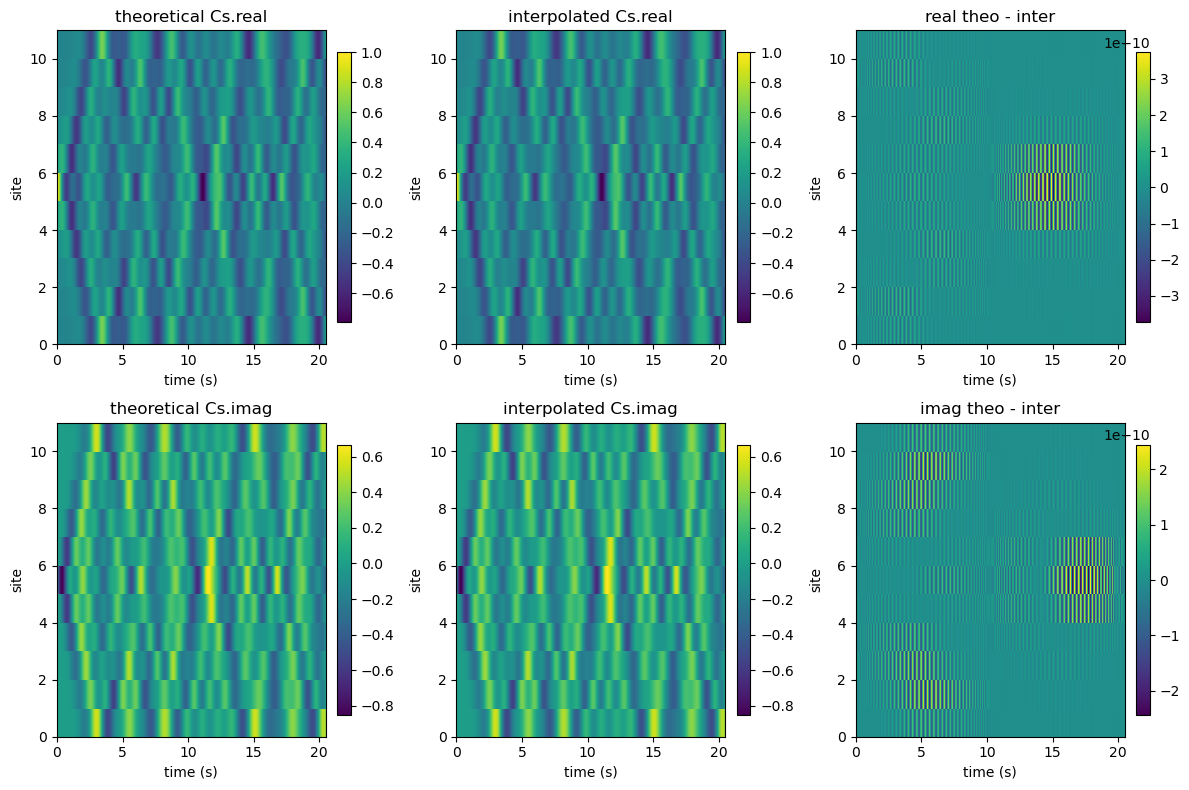

In [195]:
rows, cols = 2, 3  # Define grid dimensions
a, b = Cs.shape #Cs is in the form (X,T)
interp_Cs = func_interp.T.reshape(a, b)



# Data and titles for each subplot
data = [
    (Cs.real, 'theoretical Cs.real'),
    (np.real(interp_Cs), 'interpolated Cs.real'),
    (Cs.real - np.real(interp_Cs), 'real theo - inter'),
    (Cs.imag, 'theoretical Cs.imag'),
    (np.imag(interp_Cs), 'interpolated Cs.imag'),
    (Cs.imag - np.imag(interp_Cs), 'imag theo - inter')
]

# Create subplots
fig, axs = plt.subplots(rows, cols, figsize=(12, 8))

# Loop through data and subplots
for ax, (image, title) in zip(axs.flat, data):
    im = ax.imshow(image, aspect='auto', interpolation='none', origin = 'lower', 
                   extent = [0, N*dt, 0, L])
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)  # Add colorbar
    ax.set_title(title)
    ax.set(xlabel = 'time (s)', ylabel = 'site')

plt.tight_layout()
plt.show()

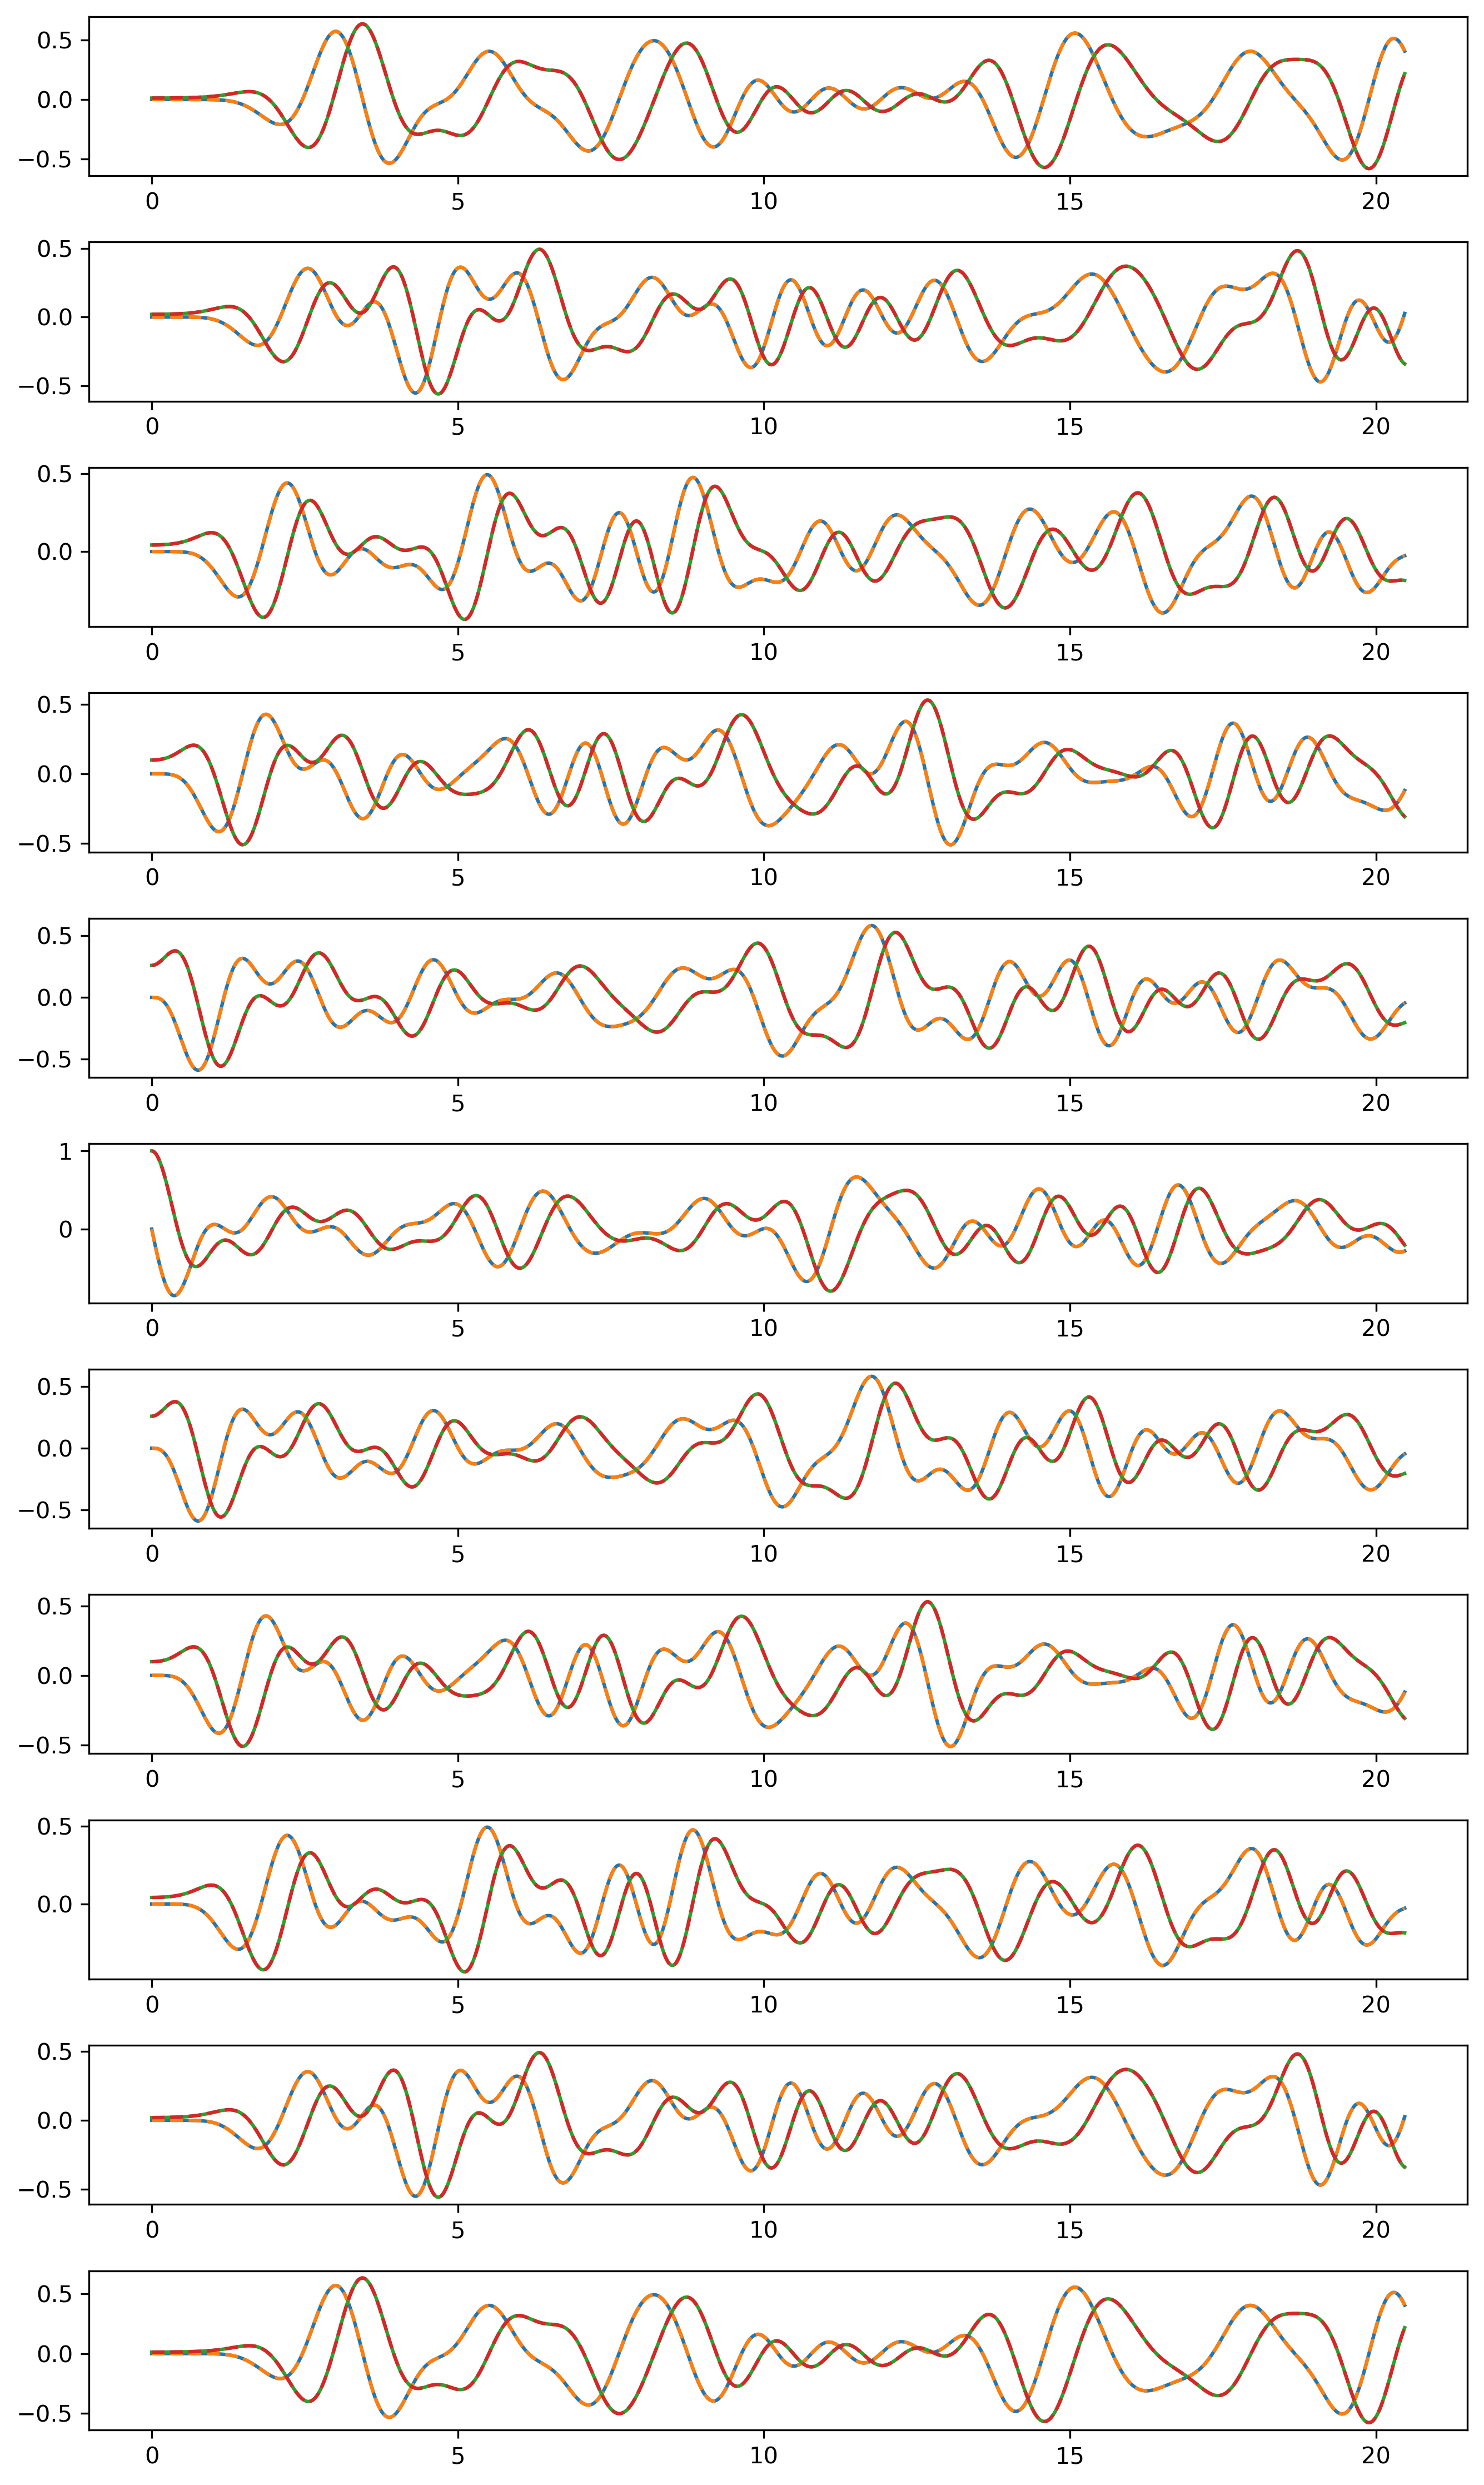

In [196]:
fig, axs = plt.subplots(nrows=D, figsize=(9,15), dpi=300)

D_list = np.arange(D)

for i,item in enumerate(D_list):
    axs[i].plot(ts, np.imag(func_vals[:,item]), '-')
    axs[i].plot(ts, np.imag(func_interp[:,item]), '--')
    axs[i].plot(ts, np.real(func_vals[:,item]), '-')
    axs[i].plot(ts, np.real(func_interp[:,item]), '--')
    #axs[i].set_xlim(0,0.2)

fig.tight_layout()

plt.show()

### Error vs evals for Chebyshev

In [200]:
#here we could define a dictionary to make things more compact
err_max = []
err_2 = []
evals = []
func_interp_list = []

# this chi_list works well for D = 11, n = 10
# chi_list = [i for i in range(2,10)]
# chi_list.extend([i for i in range(10,40,5)])
# chi_list.append(70)

#this chi_list works well for D=11, n=12
chi_list = [10,35,60,85,110,130,150,170,200]

for chi in chi_list:
# get MPS from Chebyshev interpolation
    _, eval, errmax, err2, func_interp = Cbs.Chebyshev_interpolation_Dsite(Cs_chebyshev_Dsites, # function to be interpolated
                                 func_vals,
                                 L=n,              # number of MPS tensors
                                 D = D,
                                 chi=chi)           # (half of the) bond dimension

    err_max.append(errmax)
    err_2.append(err2)
    evals.append(eval)
    func_interp_list.append(func_interp)




2 10
2 35
2 60
2 85
2 110
2 130
2 150
2 170
2 200


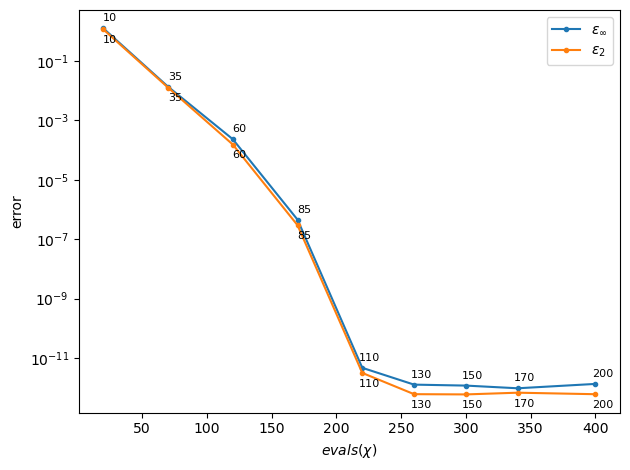

In [202]:
plt.plot(np.array(evals), np.array(err_max), ".-", label = r"$\epsilon_\infty$")
plt.plot(np.array(evals), np.array(err_2), ".-", label = r"$\epsilon_2$")

# Annotate the points with their chi values
for i, chi in enumerate(chi_list):
    # Annotate error_max (first curve)
    plt.annotate(f"{chi}", (evals[i], err_max[i]),
                 textcoords="offset points", xytext=(5, 5), fontsize=8,
                #  arrowprops=dict(arrowstyle="-", lw=0.5),
                 ha='center')

    # Annotate error_2 (second curve)
    plt.annotate(f"{chi}", (evals[i], err_2[i]),
                 textcoords="offset points", xytext=(5, -10), fontsize=8,
                #  arrowprops=dict(arrowstyle="-", lw=0.5),
                 ha='center')
    

plt.yscale("log")
plt.xlabel(r"$evals(\chi)$")
plt.ylabel(r"error")
plt.legend()
# plt.title("Error vs # of evaluations")
plt.tight_layout()
plt.savefig("Error_vs_evals_Chebyshev_Dsites_D11_n11.pdf")
plt.show()

Compute Fourier transform
finished
Compute Fourier transform
finished
512
(11,)
11
512
(11,)
11


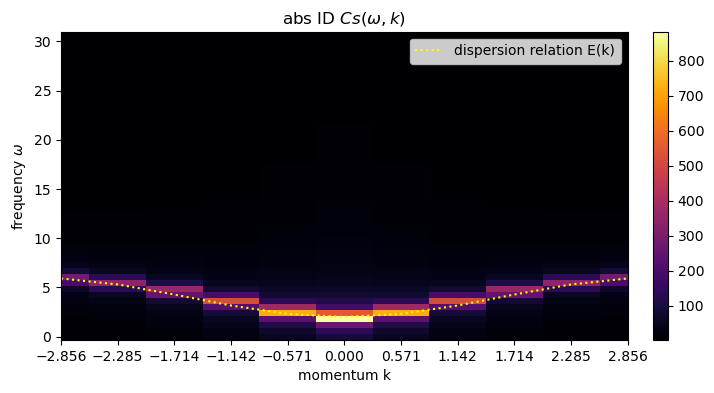

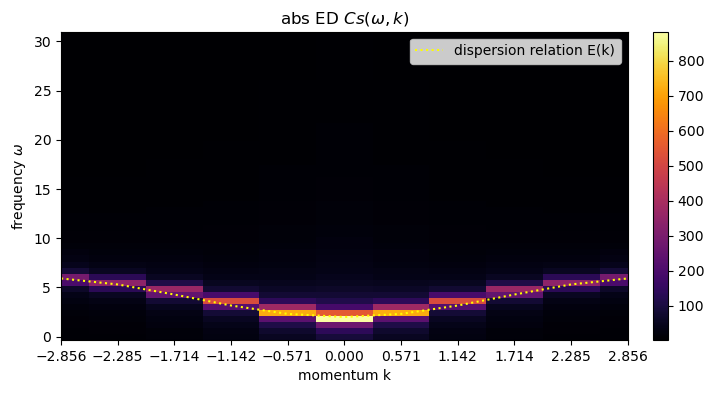

In [89]:
Swk, momenta, freqs = FT.get_Swk(Cs.T, L, dt = dt)
interp_Swk, interp_momenta, interp_freqs = FT.get_Swk(func_interp, L, dt = dt)

FT.plot_Swk(Swk, momenta, freqs, g, J, interval = 50)
FT.plot_Swk(interp_Swk, interp_momenta, interp_freqs, g, J, interval = 50, interp = True)
